In [13]:
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from scipy.signal import savgol_filter



from wOpenTimes import ( 
    WINDOW_OPEN_TIMES
)

def write_data_to_csv(data_frame: pd.DataFrame) -> None:
    """
    This function writes the data to a csv file.
    """
    now = datetime.now()
    #timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S")
    file_name = f"analasys_output_temperature.csv"
    data_frame.to_csv(file_name, index=False)


def read_collected_data() -> list[pd.DataFrame, pd.DataFrame]:
    """
    This function reads the collected data from the csv files and returns a list of two dataframes.
    The dataframes are labeled, their data is interpolated and resampled to 1 minute intervals.
    """
    
    inside_temp_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/inside_temperature.csv', parse_dates=['Time'])
    inside_temp_data = inside_temp_data.iloc[1:].reset_index(drop=True)
    inside_temp_data.columns = ['Time', 'Temperature']
    inside_temp_data['Temperature'] = inside_temp_data['Temperature'].str.replace(' °C', '', regex=False).str.strip()
    inside_temp_data['Temperature'] = pd.to_numeric(inside_temp_data['Temperature'], errors='coerce')

    outside_temp_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/outside_temperature.csv', parse_dates=['Time'])
    outside_temp_data = outside_temp_data.iloc[1:].reset_index(drop=True)
    outside_temp_data.columns = ['Time', 'Temperature']
    outside_temp_data['Temperature'] = outside_temp_data['Temperature'].str.replace(' °C', '', regex=False).str.strip()
    outside_temp_data['Temperature'] = pd.to_numeric(outside_temp_data['Temperature'], errors='coerce')

    inside_humidity_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/inside_humidity.csv', parse_dates=['Time'])
    inside_humidity_data = inside_humidity_data.iloc[1:].reset_index(drop=True)
    inside_humidity_data['Humidity'] = inside_humidity_data['Humidity'].str.replace(' %', '', regex=False).str.strip()
    inside_humidity_data['Humidity'] = pd.to_numeric(inside_humidity_data['Humidity'], errors='coerce')

    outside_humidity_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/outside_humidity.csv', parse_dates=['Time'])
    outside_humidity_data = outside_humidity_data.iloc[1:].reset_index(drop=True)
    outside_humidity_data['Humidity'] = outside_humidity_data['Humidity'].str.replace(' %', '', regex=False).str.strip()
    outside_humidity_data['Humidity'] = pd.to_numeric(outside_humidity_data['Humidity'], errors='coerce')

    outside_temp_data = outside_temp_data.set_index('Time').resample('1T').interpolate('linear').reset_index()
    inside_temp_data = inside_temp_data.set_index('Time').resample('1T').interpolate('linear').reset_index()
    inside_humidity_data = inside_humidity_data.set_index('Time').resample('1T').interpolate('linear').reset_index()
    outside_humidity_data = outside_humidity_data.set_index('Time').resample('1T').interpolate('linear').reset_index()

    data_list = [inside_temp_data, outside_temp_data, outside_humidity_data, inside_humidity_data]
    return data_list


def normalize_data(data_frame: pd.DataFrame, file_type: str) -> pd.DataFrame:
    """
    This function normalizes the data by removing outliers and interpolating the data to 1 minute intervals.
    """

    if file_type == "temperature":
        value = "Temperature"
        lower_percentile = 0.01
        upper_percentile = 99.99
    elif file_type == "humidity":
        value = "Humidity"
        lower_percentile = 0.1
        upper_percentile = 99.9
    else:
        raise ValueError("Invalid file type")

    lower_threshold = data_frame[value].quantile(lower_percentile / 100)
    upper_threshold = data_frame[value].quantile(upper_percentile / 100)

    df_filtered = data_frame[(data_frame[value] >= lower_threshold) & (data_frame[value] <= upper_threshold)]
    df_filtered = df_filtered.set_index('Time').resample('1T').interpolate('linear').reset_index()


    return df_filtered


def try_different_times(data: pd.DataFrame) -> pd.DataFrame:
    

    for i in range(1, 40):

        results = []
        for start in WINDOW_OPEN_TIMES:
            try:
                start_time = pd.to_datetime(start)
                thirty_min_later = start_time + pd.Timedelta(minutes=i)

                temp_at_start = data.loc[data['Time'] == start_time, 'Temperature_inside'].values[0]
                outside_temp_at_start = data.loc[data['Time'] == start_time, 'Temperature_outside'].values[0]
                
                #thirty_min_later = start_time + pd.Timedelta(minutes=30)
                temp_after_30_min = data.loc[data['Time'] == thirty_min_later, 'Temperature_inside'].values[0]
                outside_temp_after_30_min = data.loc[data['Time'] == thirty_min_later, 'Temperature_outside'].values[0]
                
                temp_drop = temp_at_start - temp_after_30_min
                temp_difference_at_start = temp_at_start - outside_temp_at_start
                temp_difference_at_end = temp_after_30_min - outside_temp_after_30_min
                average_temp_difference = (temp_difference_at_start + temp_difference_at_end) / 2
                cooling_rate = (temp_difference_at_start - temp_difference_at_end) / 30
                results.append({'start_time': start, 'drop_after_30_min': temp_drop, 'temp_difference_at_start': temp_difference_at_start, 'temp_difference_at_end': temp_difference_at_end, 'average_temp_difference': average_temp_difference, 'temp_at_start': temp_at_start, 'temp_after_30_min': temp_after_30_min, 'outside_temp_at_start': outside_temp_at_start, 'outside_temp_after_30_min': outside_temp_after_30_min, 'cooling_rate': cooling_rate})
            except Exception as e:
                data.to_csv("error_dump.csv", index=False)
                print(f"Error processing data for window open time: {start}, Exception: {e}")
        results_df_for_test = pd.DataFrame(results)
        results_df_for_test = results_df_for_test.round(3)
        collerate_data = results_df_for_test[['temp_difference_at_start', 'cooling_rate']]
        print(f"Correlation for {i} minutes: ")
        print(collerate_data.corr())


data_list = read_collected_data()
inside_temp_data = data_list[0]
outside_temp_data = data_list[1]
outside_humidity_data = data_list[2]
inside_humidity_data = data_list[3]

inside_temp_data = normalize_data(inside_temp_data, "temperature")
outside_temp_data = normalize_data(outside_temp_data, "temperature")

inside_humidity_data = normalize_data(inside_humidity_data, "humidity")
outside_humidity_data = normalize_data(outside_humidity_data, "humidity")

data = pd.merge_asof(inside_temp_data.sort_values('Time'), 
                outside_temp_data.sort_values('Time'), 
                on='Time', 
                suffixes=('_inside', '_outside'))

data = data.dropna()

results = []

pre_smoothed_data = data.copy()

# Smooth the temperature data
#span = 15  # Determines the degree of smoothing
#data['Temperature_inside'] = data['Temperature_inside'].ewm(span=span, adjust=False).mean()

# Apply Savitzky-Golay filter
window_size = 9  # Choose an odd number (larger values = more smoothing)
poly_order = 2    # Polynomial order
data['Temperature_inside'] = savgol_filter(data['Temperature_inside'], window_size, poly_order)


#try_different_times(data)
minutes = 30
for start in WINDOW_OPEN_TIMES:
    try:
        start_time = pd.to_datetime(start)
        temp_at_start = data.loc[data['Time'] == start_time, 'Temperature_inside'].values[0]
        outside_temp_at_start = data.loc[data['Time'] == start_time, 'Temperature_outside'].values[0]
        
        thirty_min_later = start_time + pd.Timedelta(minutes=minutes)
        temp_after_30_min = data.loc[data['Time'] == thirty_min_later, 'Temperature_inside'].values[0]
        outside_temp_after_30_min = data.loc[data['Time'] == thirty_min_later, 'Temperature_outside'].values[0]
        
        temp_drop = temp_at_start - temp_after_30_min
        temp_difference_at_start = temp_at_start - outside_temp_at_start
        temp_difference_at_end = temp_after_30_min - outside_temp_after_30_min
        average_temp_difference = (temp_difference_at_start + temp_difference_at_end) / 2
        cooling_rate = (temp_difference_at_start - temp_difference_at_end) / minutes
        results.append({'start_time': start, 'drop_after_30_min': temp_drop, 'temp_difference_at_start': temp_difference_at_start, 'temp_difference_at_end': temp_difference_at_end, 'average_temp_difference': average_temp_difference, 'temp_at_start': temp_at_start, 'temp_after_30_min': temp_after_30_min, 'outside_temp_at_start': outside_temp_at_start, 'outside_temp_after_30_min': outside_temp_after_30_min, 'cooling_rate': cooling_rate})
    except Exception as e:
        data.to_csv("error_dump.csv", index=False)
        print(f"Error processing data for window open time: {start}, Exception: {e}")

data_results = pd.DataFrame(results)
data_results = data_results.round(3)


In [14]:

collerate_data = data_results[['temp_difference_at_start', 'cooling_rate']]

X = collerate_data[['temp_difference_at_start']]
y = collerate_data['cooling_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

print(collerate_data.corr())
print(f"Model coefficient: {model.coef_[0]}")
print(f"Model intercept: {model.intercept_}")

# Fake data to simulate a prediction

temp_inside = 25.8
temp_outside = 2
temp_difference_actual = temp_inside - temp_outside

goal_temp = 22
goal_temperature_difference = goal_temp - temp_outside

minute = 0
predicted_cooling_rate = model.predict([[temp_difference_actual]])[0]

diff = temp_difference_actual - goal_temperature_difference
minutes_to_cool = diff / predicted_cooling_rate

while temp_difference_actual > goal_temperature_difference:
    temp_difference_actual -= predicted_cooling_rate
    minute += 1
    predicted_cooling_rate = model.predict([[temp_difference_actual]])[0]


#print(f"After {minute} minutes the temperature will drop from {temp_inside} to {goal_temp} degrees celsius")

print(f"Cool for {minutes_to_cool} minutes to reach the goal temperature")


                          temp_difference_at_start  cooling_rate
temp_difference_at_start                  1.000000      0.649928
cooling_rate                              0.649928      1.000000
Model coefficient: 0.01834293401613446
Model intercept: -0.26809180551430567
Cool for 22.555941455958813 minutes to reach the goal temperature


/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/util

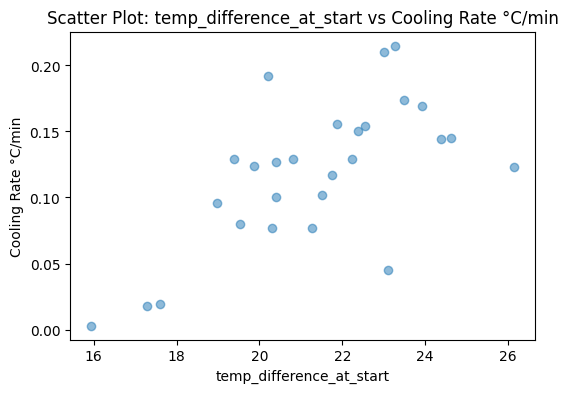

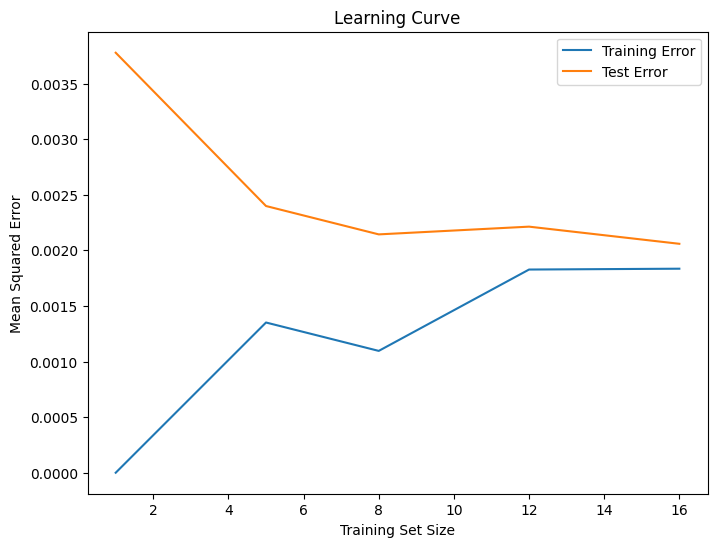

In [15]:
# Scatter plot of each feature against the target variable
for feature in X.columns:
    plt.figure(figsize=(6, 4))
    plt.scatter(X[feature], y, alpha=0.5)
    plt.title(f'Scatter Plot: {feature} vs Cooling Rate °C/min')
    plt.xlabel(feature)
    plt.ylabel('Cooling Rate °C/min')
    plt.show()


# Get learning curve data
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, -train_scores.mean(axis=1), label='Training Error')
plt.plot(train_sizes, -test_scores.mean(axis=1), label='Test Error')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve')
plt.legend()
plt.show()

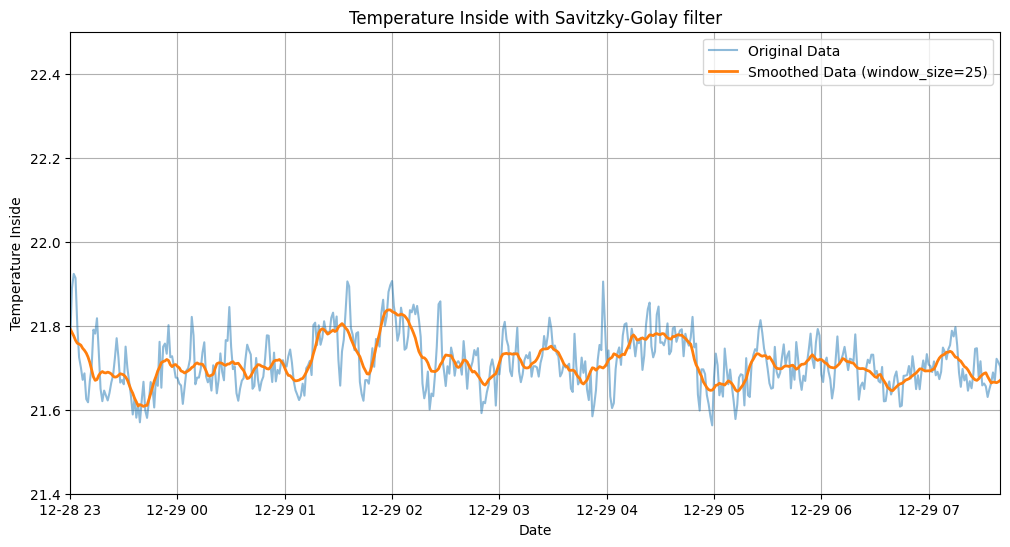

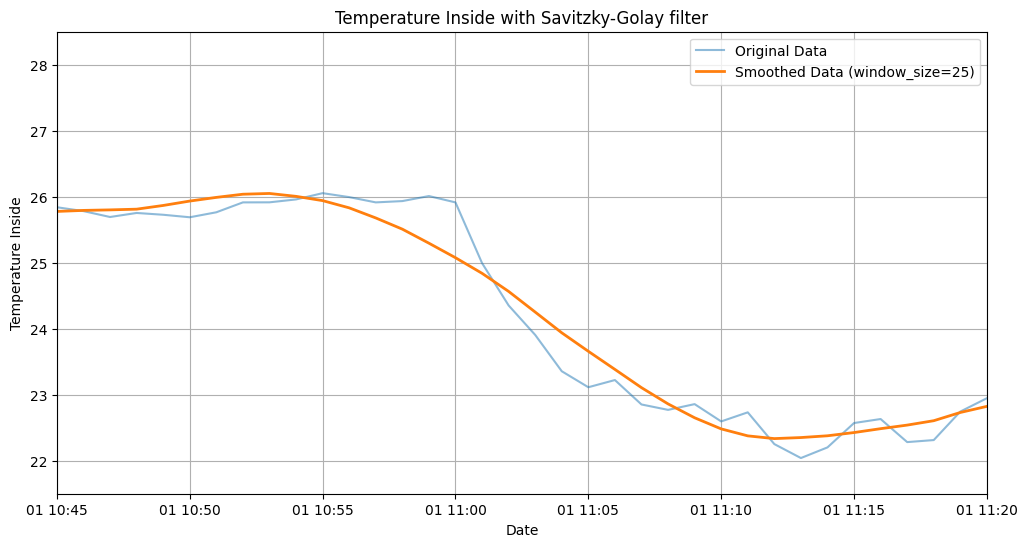

In [69]:

plt.figure(figsize=(12, 6))
plt.plot(pre_smoothed_data['Time'], pre_smoothed_data['Temperature_inside'], label='Original Data', alpha=0.5)
plt.plot(data['Time'], data['Temperature_inside'], label=f'Smoothed Data (window_size={window_size})', linewidth=2)
plt.xlim(datetime(2024, 12, 28, 23, 00), datetime(2024, 12, 29, 7, 40))
plt.ylim(21.4, 22.5)
plt.title('Temperature Inside with Savitzky-Golay filter')
plt.xlabel('Date')
plt.ylabel('Temperature Inside')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(pre_smoothed_data['Time'], pre_smoothed_data['Temperature_inside'], label='Original Data', alpha=0.5)
plt.plot(data['Time'], data['Temperature_inside'], label=f'Smoothed Data (window_size={window_size})', linewidth=2)
plt.xlim(datetime(2025, 1, 1, 10, 45), datetime(2025, 1, 1, 11, 20))
plt.ylim(21.5, 28.5)
plt.title('Temperature Inside with Savitzky-Golay filter')
plt.xlabel('Date')
plt.ylabel('Temperature Inside')
plt.legend()
plt.grid()
plt.show()
